# Project: Analysis of medical appointment data in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#data_details">Dataset Details</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

## Introduction <a id='intro'></a>


The purpose of this document is to analyze a medical appointment dataset. This dataset consists of information from 100k medical appointments in Brazil, mainly focusing on whether or not patients show up for their appointment.

#### The following questions will be explored :
 1. What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?
 2. What is the proportion of men & women who register for medical appointments?
 3. Which neighbourhoods report the most medical problems?
 4. Is aging correlated to medical problems such as hypertension, diabetes, etc.?

<a id='data_details'></a>
## Dataset Details

 **Link :** https://www.kaggle.com/joniarroba/noshowappointments

 **Characteristics :**

 - **PatientId** : Identification of a patient 
 - **AppointmentID** : Identification of each appointment 
 - **Gender** : Male or Female
 - **ScheduledDay** : On what day the patient set up their appointment (will always be before or on the appointment day)
 - **AppointmentDay** : The actual appointment date
 - **Age** : How old is the patient.
 - **Neighbourhood** : Location of the hospital
 - **Scholarship** : indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
 - **Hipertension** : 1 for True and 0 for False 
 - **Diabetes** : True or False
 - **Alcoholism** : True or False
 - **Handcap** : True or False
 - **SMS_received** : 1 or more messages sent to the patient.
 - **No-show** : 'No' means patient showed up, and 'Yes' means they didn't show up

## Import Statements

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Customization of the seaborn graphs
sns.set(style="whitegrid", color_codes=True)

<a id='wrangling'></a>
## Data Wrangling

### Loading CSV Data and initial cleaning

**Note :** During loading itself, we are cleaning up the following aspects of the data : 

1. Data types of the ID columns are set to string (e.g. 'PatientId' and 'AppointmentID' should be of type string)
2. Columns containing dates are parsed
3. Boolean fields are converted to bool type from the string values

In [2]:
def string_to_bool(value):
    '''Type converter for columns to map the value of '1' to boolean True'''
    return value == '1' 

def no_show_to_bool(value):
    '''Type converter for columns to map the value of 'Yes' to boolean True'''
    return value == 'Yes'

def sms_received_to_bool(value):
    '''Type converter for determing whether one or more SMS has been received by the patient'''
    return int(value) > 0

appointment_data = pd.read_csv('noshowappointments-kagglev2-may-2016.csv', 
                               dtype={'PatientId': str, 'AppointmentID' : str},
                               parse_dates = ['ScheduledDay', 'AppointmentDay'],
                               converters = {'Scholarship': string_to_bool,
                                             'Hipertension': string_to_bool,
                                             'Diabetes': string_to_bool,
                                             'Alcoholism': string_to_bool,
                                             'Handcap': string_to_bool,
                                             'SMS_received': sms_received_to_bool,
                                             'No-show' : no_show_to_bool},
                               encoding = "utf8"
                              )

# Check the data types (whether loaded correctly or not)
appointment_data.dtypes

PatientId                 object
AppointmentID             object
Gender                    object
ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood             object
Scholarship                 bool
Hipertension                bool
Diabetes                    bool
Alcoholism                  bool
Handcap                     bool
SMS_received                bool
No-show                     bool
dtype: object

**Initial Sample data (first 5 rows)**

In [3]:
appointment_data.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,False
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,False
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,False
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,False
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,False


**Check for null values (i.e. NaN) :** There are no null values in the dataset as analyzed below : 

In [4]:
appointment_data.isnull().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

### Further cleaning

There are still some problems remaining in the dataset that need to be cleaned : 

1. The columnns that have a typo in their names need to be renamed
2. The column 'Age' has erroneous values (negative age) and such rows need to be deleted
3. Additional derived columns need to be added for further analysis
4. Records having negative Gap Days (i.e. Appointment Date is before the Scheduled Date) need to be removed

The details are as follows : 

**1. Rename columns having typos**

In [5]:
appointment_data.rename(columns={'PatientId':'PatientID', 'Hipertension':'Hypertension','Handcap':'Handicap'}, inplace = True)

**2. Remove row(s) having negative age**

In [6]:
print 'Initial row count : ', len(appointment_data.index)
appointment_data = appointment_data[appointment_data['Age'] >= 0]
print 'Final row count after cleaning negative age records : ', len(appointment_data.index)

Initial row count :  110527
Final row count after cleaning negative age records :  110526


**3. Add additional derived columns**

1. GapDays : This column (int64) denotes the interval (in days) between between the appointment day and the scheduled day.
2. MedicalCondition : This column (boolean) denotes whether or not the patient suffers from one of the four medical conditions - Hypertension, Diabetes, Alcoholism, or Handicap.

In [7]:
appointment_data['GapDays'] = (appointment_data['AppointmentDay'].dt.date - appointment_data['ScheduledDay'].dt.date).dt.days
appointment_data['MedicalCondition'] = appointment_data['Hypertension'] | appointment_data['Diabetes'] | appointment_data['Alcoholism'] | appointment_data['Handicap']

**4. Remove erroroneous 'GapDays' records**

Appointment date cannot be before the schedule date. Hence, these records are removed.

The following are the erroneous records : 

In [8]:
appointment_data[appointment_data['GapDays'] < 0]

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,GapDays,MedicalCondition
27033,7839272661752,5679978,M,2016-05-10 10:51:53,2016-05-09,38,RESISTÊNCIA,False,False,False,False,True,False,True,-1,True
55226,7896293967868,5715660,F,2016-05-18 14:50:41,2016-05-17,19,SANTO ANTÔNIO,False,False,False,False,True,False,True,-1,True
64175,24252258389979,5664962,F,2016-05-05 13:43:58,2016-05-04,22,CONSOLAÇÃO,False,False,False,False,False,False,True,-1,False
71533,998231581612122,5686628,F,2016-05-11 13:49:20,2016-05-05,81,SANTO ANTÔNIO,False,False,False,False,False,False,True,-6,False
72362,3787481966821,5655637,M,2016-05-04 06:50:57,2016-05-03,7,TABUAZEIRO,False,False,False,False,False,False,True,-1,False


In [9]:
# Remove the erroneous records
appointment_data = appointment_data[appointment_data['GapDays'] >= 0]

**Final sample data after cleaning (first 6 rows)**

In [10]:
print appointment_data.dtypes
appointment_data.head(6)

PatientID                   object
AppointmentID               object
Gender                      object
ScheduledDay        datetime64[ns]
AppointmentDay      datetime64[ns]
Age                          int64
Neighbourhood               object
Scholarship                   bool
Hypertension                  bool
Diabetes                      bool
Alcoholism                    bool
Handicap                      bool
SMS_received                  bool
No-show                       bool
GapDays                      int64
MedicalCondition              bool
dtype: object


,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,GapDays,MedicalCondition
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,False,0,True
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,False,0,False
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,False,0,False
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,False,0,False
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,False,0,True
5,95985133231274,5626772,F,2016-04-27 08:36:51,2016-04-29,76,REPÚBLICA,False,True,False,False,False,False,False,2,True


<a id='eda'></a>
## Exploratory Data Analysis

### Correlation Matrix

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,GapDays,MedicalCondition
Age,1.000000,-0.092469,0.504599,0.292398,0.095811,0.081815,0.012629,-0.060320,0.034813,0.509312
Scholarship,-0.092469,1.000000,-0.019738,-0.024899,0.035019,-0.009139,0.001182,0.029166,-0.030435,-0.009966
Hypertension,0.504599,-0.019738,1.000000,0.433082,0.087967,0.081187,-0.006285,-0.035662,-0.017236,0.887052
Diabetes,0.292398,-0.024899,0.433082,1.000000,0.018471,0.054499,-0.014561,-0.015158,-0.027200,0.497951
Alcoholism,0.095811,0.035019,0.087967,0.018471,1.000000,0.003125,-0.026154,-0.000181,-0.038527,0.316864
Handicap,0.081815,-0.009139,0.081187,0.054499,0.003125,1.000000,-0.023890,-0.008017,-0.020314,0.245392
SMS_received,0.012629,0.001182,-0.006285,-0.014561,-0.026154,-0.023890,1.000000,0.126502,0.398128,-0.019694
No-show,-0.060320,0.029166,-0.035662,-0.015158,-0.000181,-0.008017,0.126502,1.000000,0.186320,-0.032401
GapDays,0.034813,-0.030435,-0.017236,-0.027200,-0.038527,-0.020314,0.398128,0.186320,1.000000,-0.033690
MedicalCondition,0.509312,-0.009966,0.887052,0.497951,0.316864,0.245392,-0.019694,-0.032401,-0.033690,1.000000


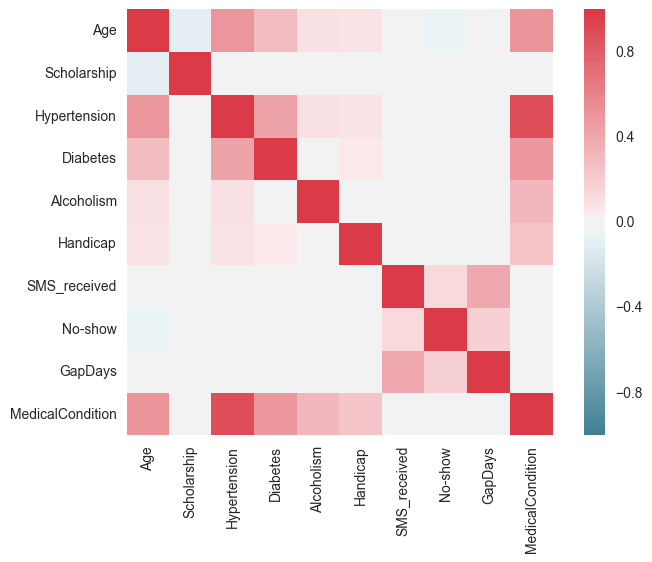

In [11]:
correlation_matrix = appointment_data.corr()
sns.heatmap(correlation_matrix, 
            mask=np.zeros_like(correlation_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
correlation_matrix

In [12]:
correlation_matrix['No-show'].drop('No-show').sort_values(ascending = False, inplace = False)

GapDays             0.186320
SMS_received        0.126502
Scholarship         0.029166
Alcoholism         -0.000181
Handicap           -0.008017
Diabetes           -0.015158
MedicalCondition   -0.032401
Hypertension       -0.035662
Age                -0.060320
Name: No-show, dtype: float64

### Exploration of the factors that may affect no-show rate

**Exploration of Factor 1 :** Age

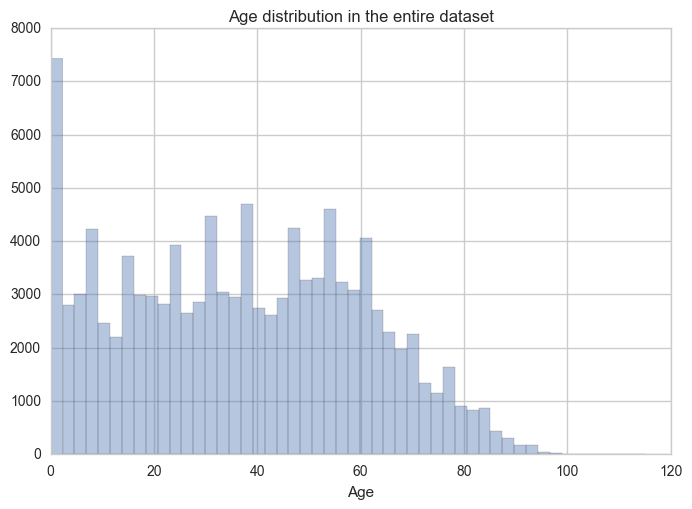

Overall Age Distribution statistics :


count    110521.000000
mean         37.089386
std          23.109885
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

In [13]:
# Plot the age distribution graph
sns.distplot(appointment_data['Age'], kde=False)
plt.title('Age distribution in the entire dataset')
plt.show()

print 'Overall Age Distribution statistics :'
appointment_data['Age'].describe()

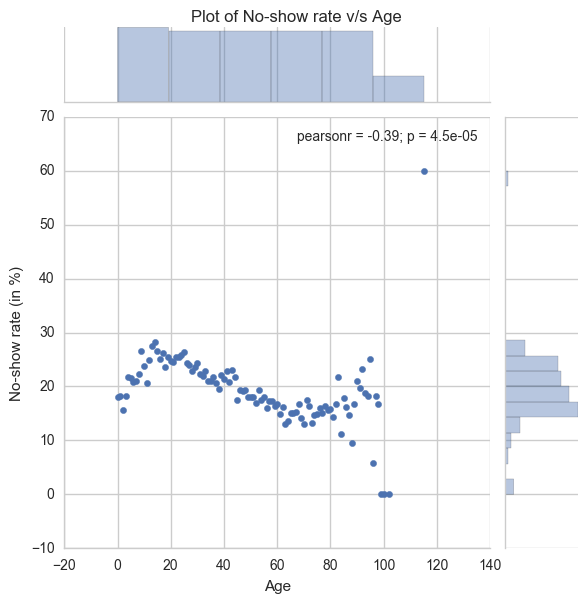

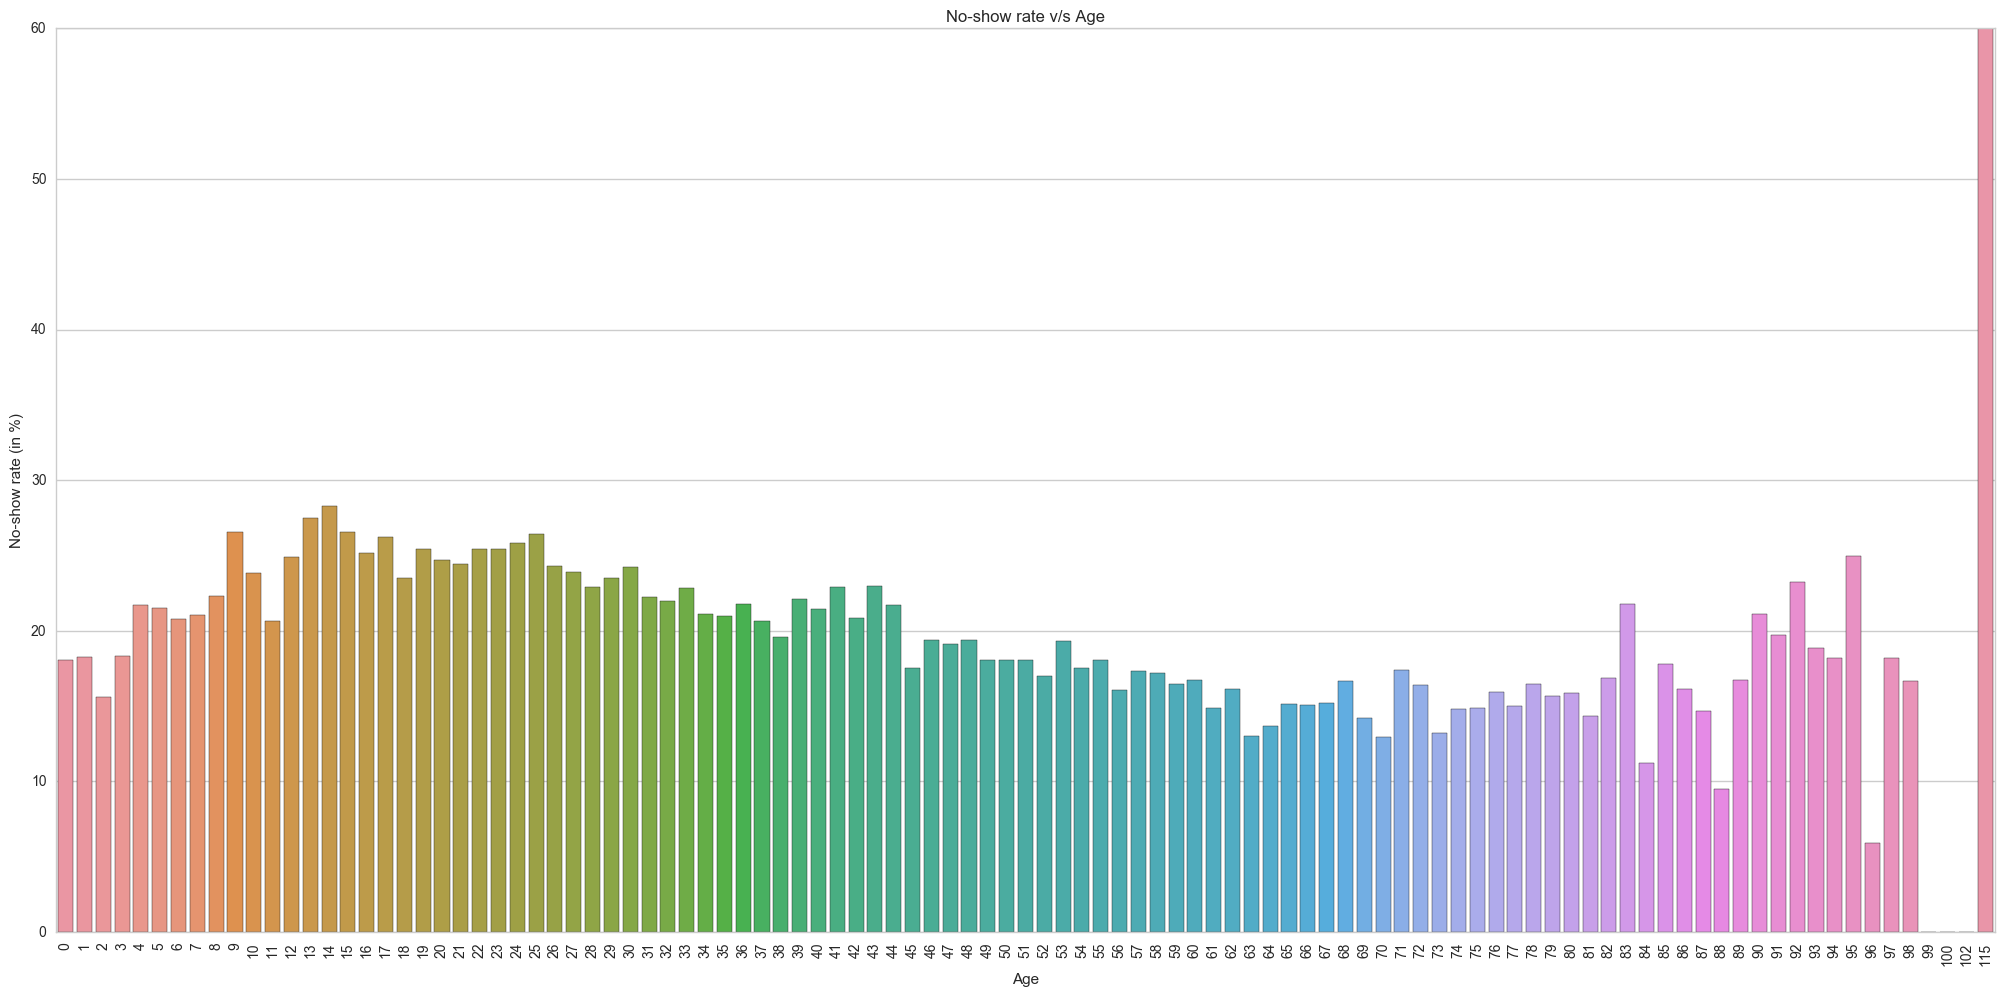

Statistics of the no-show rate distribution across ages
count    103.000000
mean      19.268425
std        6.703958
min        0.000000
25%       16.156191
50%       18.867925
75%       22.858630
max       60.000000
Name: No-show, dtype: float64


In [14]:
# Plot the no-show v/s age graphs
age_noshow_data = appointment_data.groupby('Age')['No-show'].mean() * 100

# Joint plot
grid = sns.jointplot(y=age_noshow_data, x=age_noshow_data.index)
plt.suptitle('Plot of No-show rate v/s Age', y=1)
grid.ax_joint.set_xlabel('Age')
grid.ax_joint.set_ylabel('No-show rate (in %)')

# Bar Plot
plt.figure(figsize=(20,10)) 
ax = sns.barplot(x=age_noshow_data.index, y = age_noshow_data.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
ax.set(title = 'No-show rate v/s Age', xlabel='Age', ylabel='No-show rate (in %)')
plt.show()

# Show statistics for the above
print 'Statistics of the no-show rate distribution across ages'
print age_noshow_data.describe()

**Observations for the 'Age' factor** : 
- Overall, the distribution of age-groups in the data-set is positively skewed. In other words, there is less data available in the data-set for the higher age groups(70+), which is expected.
- There seems to be a relatively higher rate of no-show between the ages of 12-25.
- Also, in the higher age groups (90+) it seems that there is again an increase of no-show. However, there are relatively very few records in this age group (which is expected).
- The lowest no-show rates are in the group of 60-80 year olds.

**Exploration of Factor 2 :** Gender

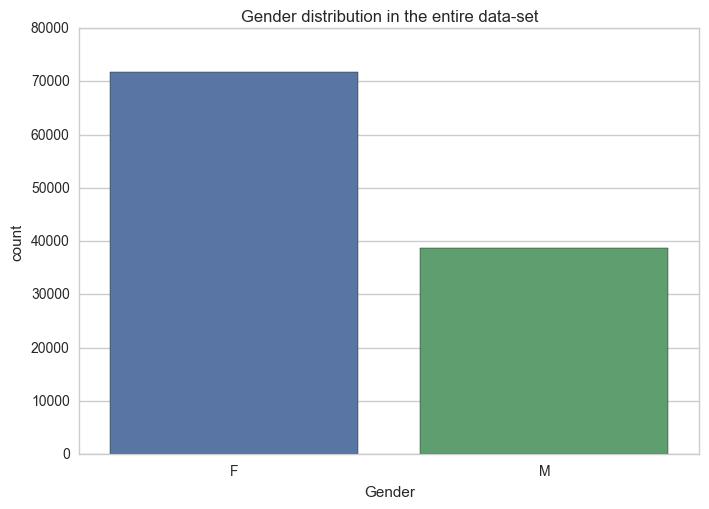

,PatientID,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,GapDays,MedicalCondition
Gender,,,,,,,,,,,,,,,
F,71836,71836,71836,71836,71836,71836,71836,71836,71836,71836,71836,71836,71836,71836,71836
M,38685,38685,38685,38685,38685,38685,38685,38685,38685,38685,38685,38685,38685,38685,38685


In [15]:
# Plot the Gender distribution graph
sns.countplot(appointment_data['Gender'])
plt.title('Gender distribution in the entire data-set')
plt.show()

appointment_data.groupby('Gender').count()

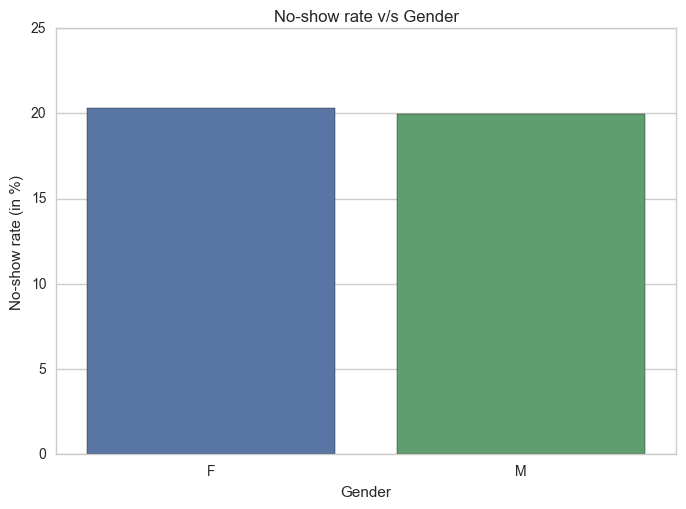

Statistics of the no-show rate distribution across Genders
count     2.000000
mean     20.137677
std       0.245884
min      19.963810
25%      20.050743
50%      20.137677
75%      20.224610
max      20.311543
Name: No-show, dtype: float64


In [16]:
# Plot the no-show v/s Gender graph
gender_noshow_data = appointment_data.groupby('Gender')['No-show'].mean() * 100.0
ax = sns.barplot(x=gender_noshow_data.index, y = gender_noshow_data)
ax.set(title = 'No-show rate v/s Gender', xlabel='Gender', ylabel='No-show rate (in %)')
plt.show()

# Show statistics for the above
print 'Statistics of the no-show rate distribution across Genders'
print gender_noshow_data.describe()

**Observations for the 'Gender' factor** : 
- Overall, there are 1.85 times more female applicants than male applicants, which is quite surprising.
- There doesn't seem to be much of a difference in the no-show rate with respect to gender (less than half a percent).

**Exploration of Factor 3 :** Neighbourhood location

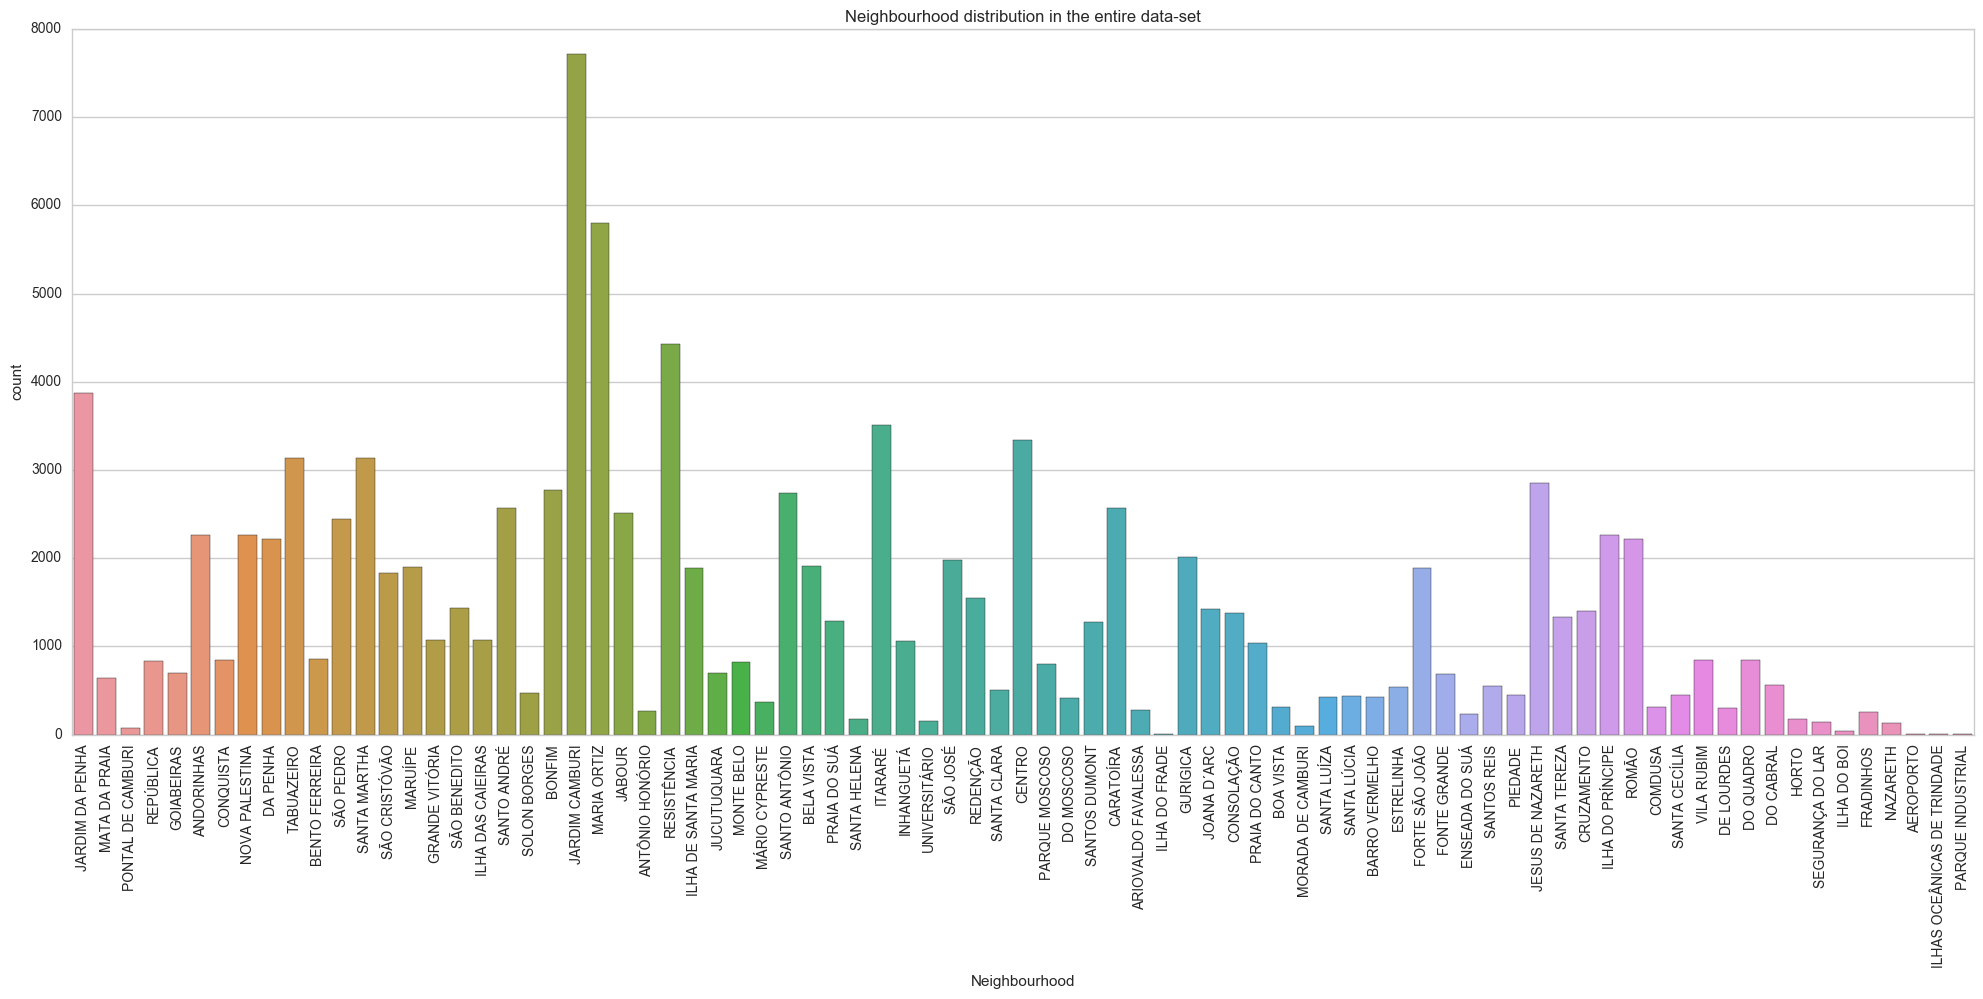

In [17]:
# Plot the Neighbourhood distribution graph
plt.figure(figsize=(20,10)) 
ax = sns.countplot(appointment_data['Neighbourhood'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.title('Neighbourhood distribution in the entire data-set')
plt.show()

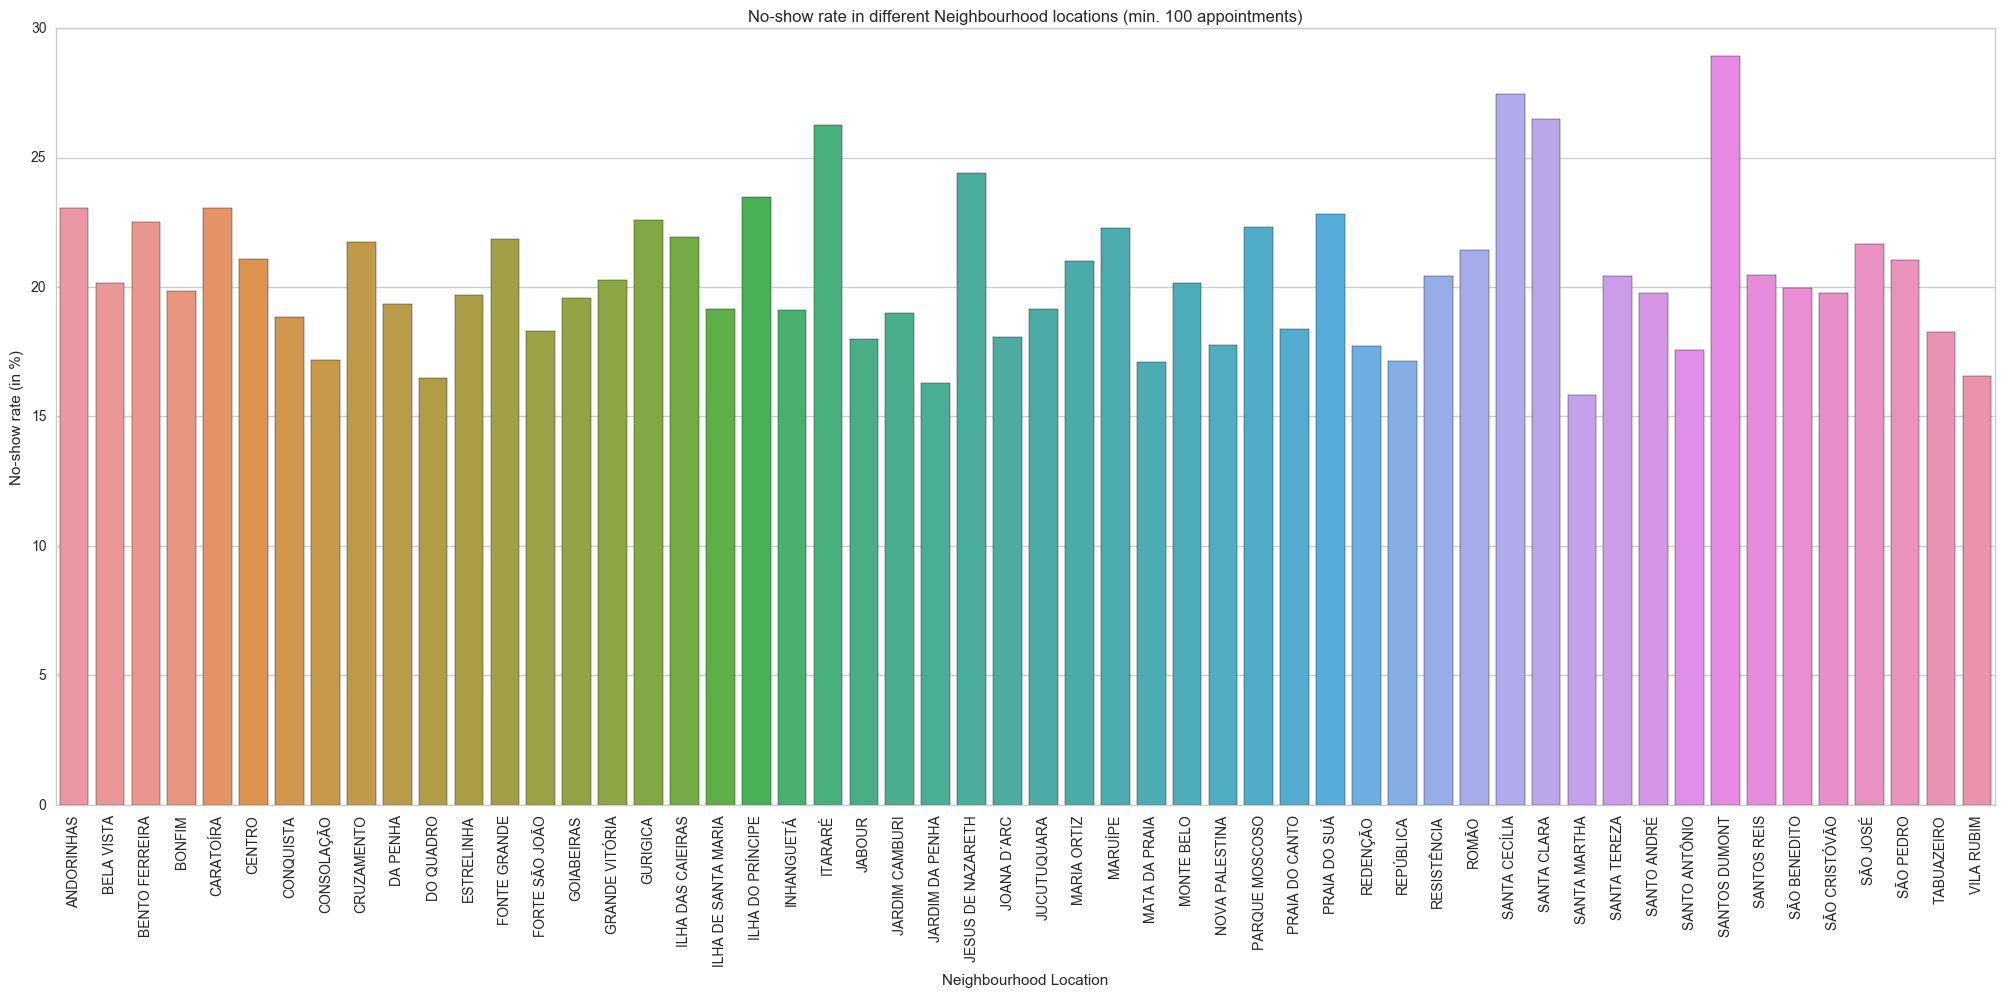

Statistics of the no-show rate distribution across Neighbourhood locations (min. 100 appointments)
count    54.000000
mean     20.424881
std       2.831800
min      15.841584
25%      18.326799
50%      20.040373
75%      21.918459
max      28.918495
Name: No-show, dtype: float64


In [18]:
# Plot the No-show v/s Neighbourhood graph

neighbourhood_noshow_data = appointment_data.groupby('Neighbourhood')['No-show'].mean() * 100.0
# Filter the neighbourhood outliers: the no. of appointments coming from there should be at least 100
neighbourhood_noshow_data = neighbourhood_noshow_data[appointment_data.groupby('Neighbourhood')['No-show'].sum() >= 100]
plt.figure(figsize=(20,10)) 
ax = sns.barplot(x=neighbourhood_noshow_data.index, y = neighbourhood_noshow_data.values, orient = 'v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
ax.set(title = 'No-show rate in different Neighbourhood locations (min. 100 appointments)', xlabel='Neighbourhood Location', ylabel='No-show rate (in %)')
plt.show()

# Show statistics for the above
print 'Statistics of the no-show rate distribution across Neighbourhood locations (min. 100 appointments)'
print neighbourhood_noshow_data.describe()

**Observations for the 'Neighbourhood' factor** : 
- Overall, there is a big variation in the appointment applications from different neighbourhoods. The majority of applications come from places like Jardim Camburi, Maria Ortiz, and Resistência. At the same time, there are a lot of neighbourhoods from where very few people apply for appointments.
- In the no-show distribution in different neighbourhoods, there are only 2 records for 'ILHAS OCEÃ‚NICAS DE TRINDADE' and both are no-show. Hence, the percentage is abnormally high (i.e. as much as 100%). Hence, outlier neighbourhoods have been filtered (with minimum no. of appointments set to 100) before plotting the graph.
- Essentially, some neighbourhoods seem to have a much larger no-show rate than average. A possible reason could be that these regions are farther away from the hospital, making it more difficult for patients to reach there.

**Exploration of Factor 4 :** Scholarship

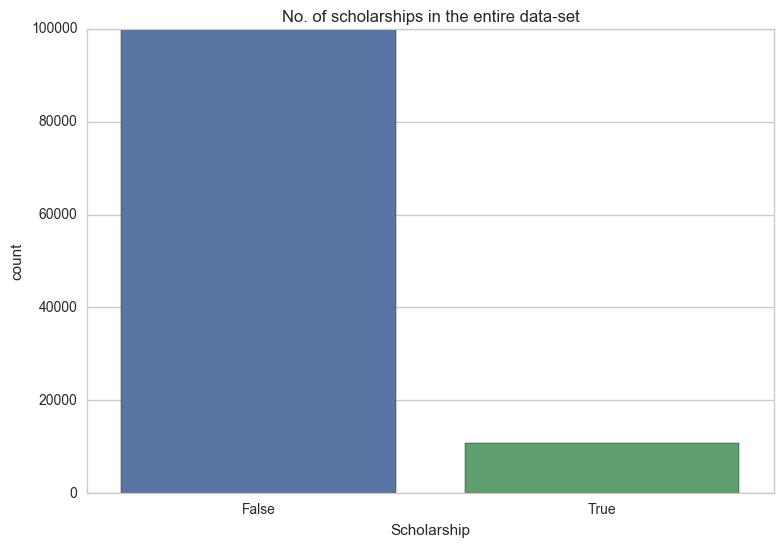

In [19]:
# Plot the Scholarship distribution graph
ax = sns.countplot(appointment_data['Scholarship'])
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.title('No. of scholarships in the entire data-set')
plt.show()

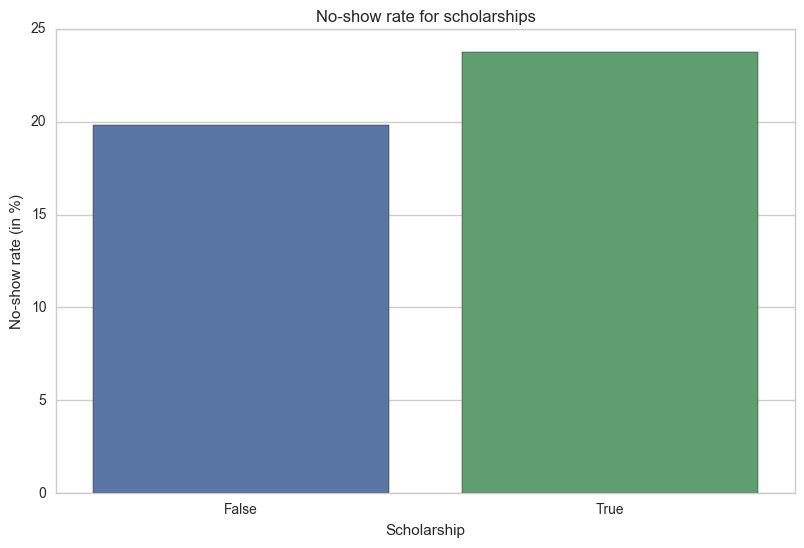

Statistics of the no-show rate distribution for scholarships
count     2.000000
mean     21.769818
std       2.781032
min      19.803331
25%      20.786575
50%      21.769818
75%      22.753061
max      23.736304
Name: No-show, dtype: float64


In [20]:
# Plot the No show rate v/s Scholarship graph

scholarship_noshow_data = appointment_data.groupby('Scholarship')['No-show'].mean() * 100.0
ax = sns.barplot(x=scholarship_noshow_data.index, y = scholarship_noshow_data.values, orient = 'v')
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
ax.set(title = 'No-show rate for scholarships', xlabel='Scholarship', ylabel='No-show rate (in %)')
plt.show()

# Show statistics for the above
print 'Statistics of the no-show rate distribution for scholarships'
print scholarship_noshow_data.describe()

**Observations for the 'Scholarship' factor** : 
- Overall, there are 10 times as many patients who haven't got a scholarship compared to those who have. This seems to be normal.
- In the no-show distribution, surprisingly, people who have a scholarship have a higher no-show rate than those who don't (23.74% vs 19.8%).

**Exploration of Factor 5 :** SMS received by patients

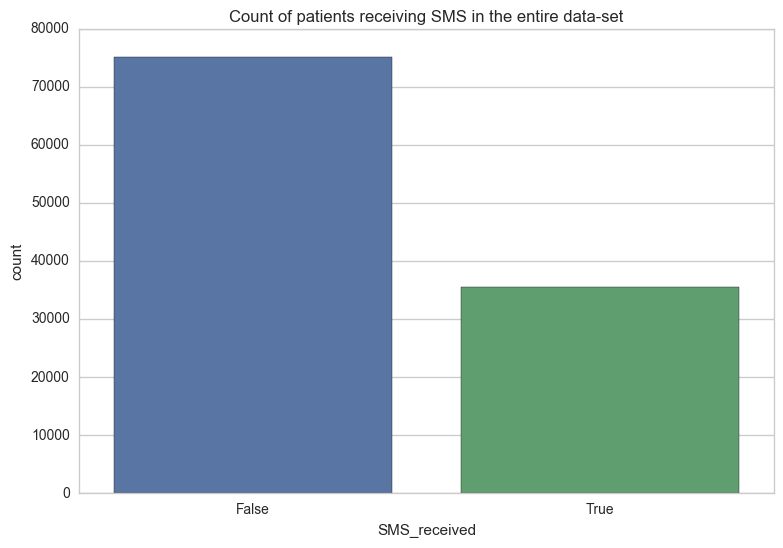

In [21]:
# Plot the SMS received distribution graph
ax = sns.countplot(appointment_data['SMS_received'])
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.title('Count of patients receiving SMS in the entire data-set')
plt.show()

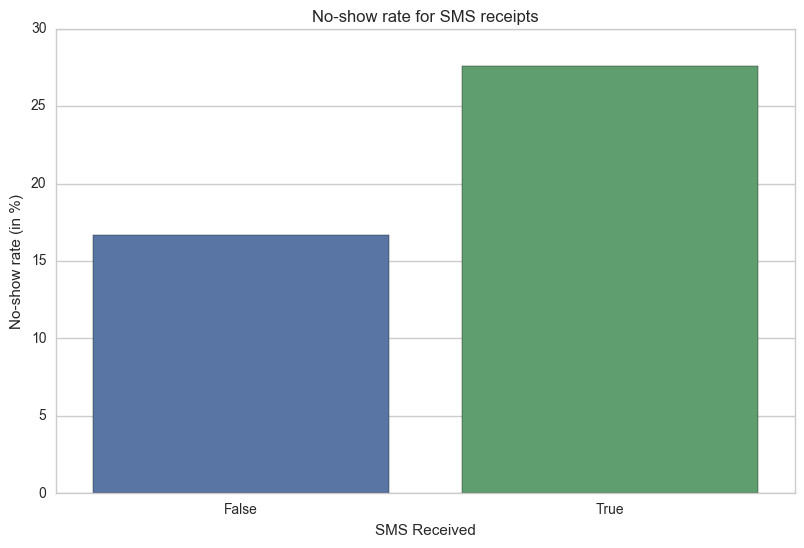

Statistics of the no-show rate distribution for SMS receipts
count     2.000000
mean     22.136264
std       7.690890
min      16.697984
25%      19.417124
50%      22.136264
75%      24.855405
max      27.574545
Name: No-show, dtype: float64


In [22]:
# Plot the No-show rate v/s SMS received graph

sms_noshow_data = appointment_data.groupby('SMS_received')['No-show'].mean() * 100.0
ax = sns.barplot(x=sms_noshow_data.index, y = sms_noshow_data.values, orient = 'v')
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
ax.set(title = 'No-show rate for SMS receipts', xlabel='SMS Received', ylabel='No-show rate (in %)')
plt.show()

# Show statistics for the above
print 'Statistics of the no-show rate distribution for SMS receipts'
print sms_noshow_data.describe()

**Observations for the 'SMS Received' factor** : 
- Overall, there are twice as many patients who haven't received an SMS compared to those who have.
- Very surprisingly, sending an SMS doesn't seem to influence patients to show up for the appointment. In fact, no-show rates are much higher when patients receive SMS (27.6% vs 16.7%).

**Exploration of Factor 6 :** Gaps in days between Appointment Day and Scheduled Day

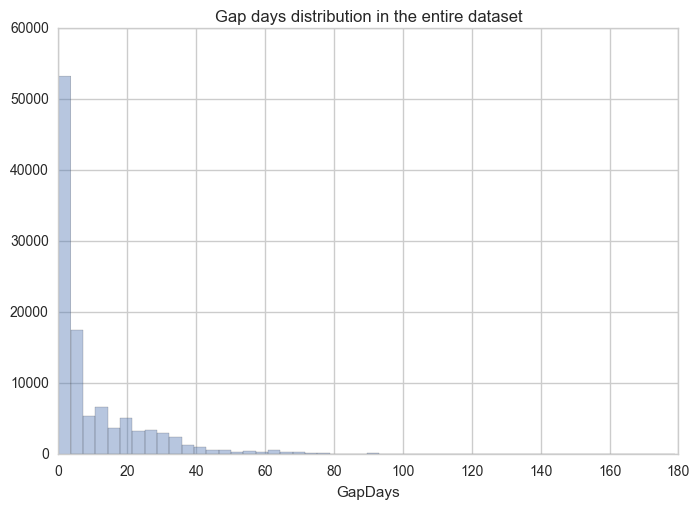

Overall Gap Days distribution statistics


count    110521.000000
mean         10.184345
std          15.255153
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: GapDays, dtype: float64

In [23]:
# Plot the Gap days distribution graph
sns.distplot(appointment_data['GapDays'], kde=False)
plt.title('Gap days distribution in the entire dataset')
plt.show()

print 'Overall Gap Days distribution statistics'
appointment_data['GapDays'].describe()

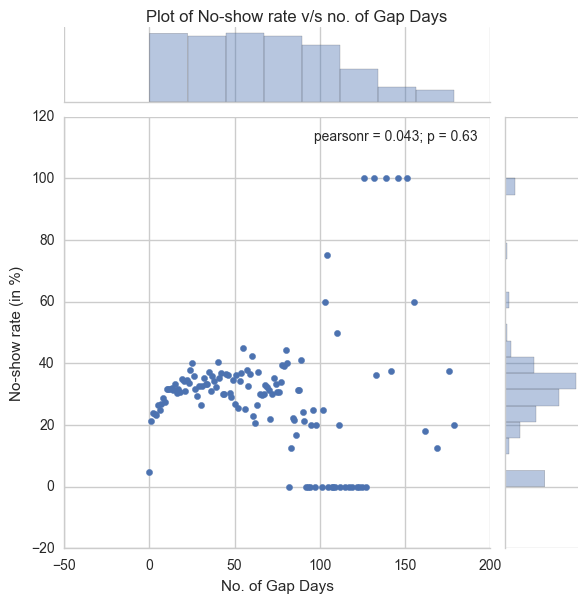

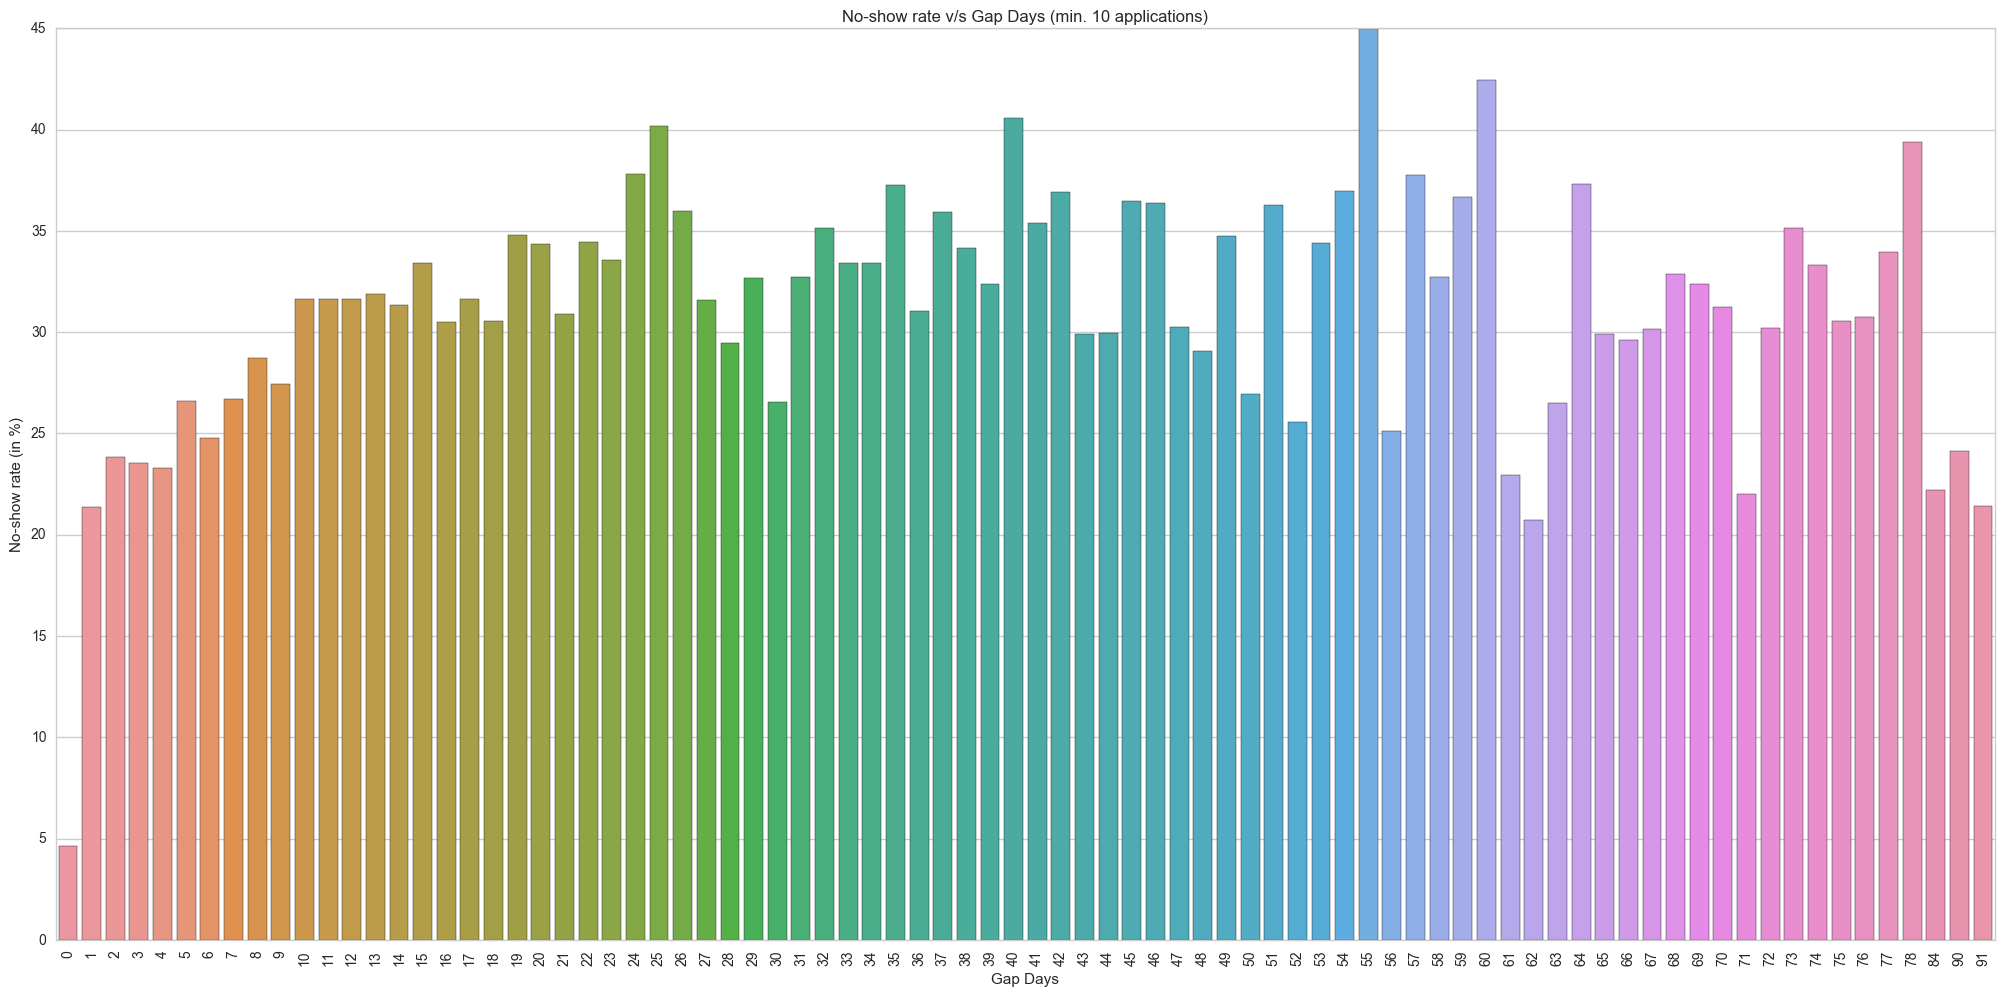

Statistics of the no-show rate distribution for Gap Days (min. 10 applications)
count    82.000000
mean     31.209141
std       5.893434
min       4.647062
25%      28.812985
50%      31.624451
75%      34.758142
max      44.954128
Name: No-show, dtype: float64


In [24]:
# Plot the No-show rate v/s Gap Days graph

gapdays_noshow_data = appointment_data.groupby('GapDays')['No-show'].mean() * 100.0

# Joint plot
grid = sns.jointplot(y=gapdays_noshow_data, x=gapdays_noshow_data.index)
plt.suptitle('Plot of No-show rate v/s no. of Gap Days', y=1)
grid.ax_joint.set_xlabel('No. of Gap Days')
grid.ax_joint.set_ylabel('No-show rate (in %)')

# Bar Plot with filtered data (no. of applications >= 10 for that gap day)
filtered_gapdays_noshow_data = gapdays_noshow_data[appointment_data.groupby('GapDays')['No-show'].sum() >= 10]
plt.figure(figsize=(20,10)) 
ax = sns.barplot(x=filtered_gapdays_noshow_data.index, y = filtered_gapdays_noshow_data.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
ax.set(title = 'No-show rate v/s Gap Days (min. 10 applications)', xlabel='Gap Days', ylabel='No-show rate (in %)')
plt.show()

# Show statistics for the above
print 'Statistics of the no-show rate distribution for Gap Days (min. 10 applications)'
print filtered_gapdays_noshow_data.describe()

**Observations for the 'Gap Days' factor** : 
- The overall distribution of Gap Days in the data-set is positively skewed. It ranges from 0 to 179 days.
- The no-show rate is lowest when the gap days is 0, i.e. when appointment day is same as scheduled day.
- When there is a greater gap, the no-show rate tends to increase.

**Exploration of Factor 7 :** Medical condition

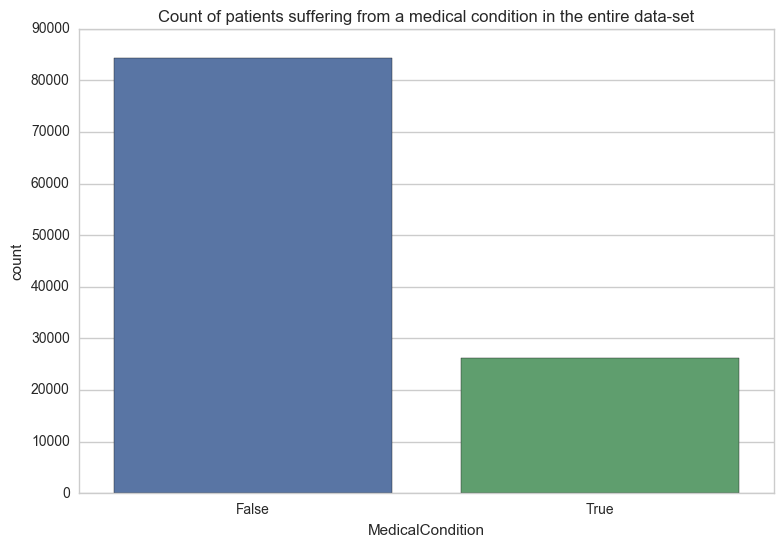

In [25]:
# Plot the Medical Condition distribution graph
ax = sns.countplot(appointment_data['MedicalCondition'])
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.title('Count of patients suffering from a medical condition in the entire data-set')
plt.show()

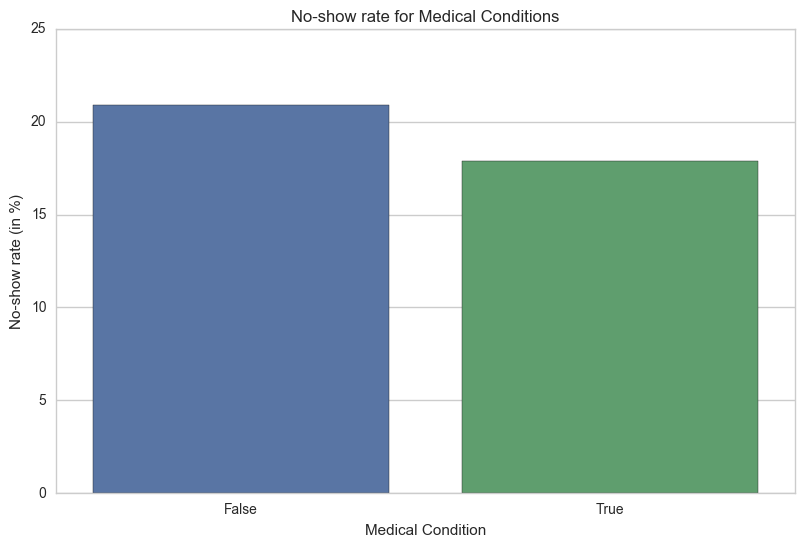

Statistics of the no-show rate distribution for Medical Conditions
count     2.000000
mean     19.389543
std       2.159651
min      17.862439
25%      18.625991
50%      19.389543
75%      20.153095
max      20.916647
Name: No-show, dtype: float64


In [26]:
# Plot the No-show rate v/s Medical Condition graph

medcond_noshow_data = appointment_data.groupby('MedicalCondition')['No-show'].mean() * 100.0
ax = sns.barplot(x=medcond_noshow_data.index, y = medcond_noshow_data.values, orient = 'v')
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
ax.set(title = 'No-show rate for Medical Conditions', xlabel='Medical Condition', ylabel='No-show rate (in %)')
plt.show()

# Show statistics for the above
print 'Statistics of the no-show rate distribution for Medical Conditions'
print medcond_noshow_data.describe()

**Observations for the 'Medical Condition' factor** : 
- Overall, there are thrice as many patients who don't seem to have any medical condition compared to those who have.
- There is only a 3% increase in no-show rates when patients do not suffer from any of the medical conditions.

### Exploration of how aging affects medical problems

(0, 150.0)

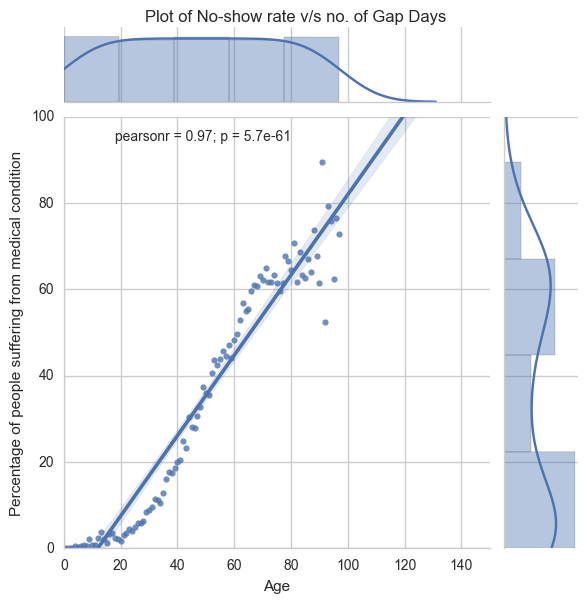

In [27]:
medcond_age_data = appointment_data.groupby('Age')['MedicalCondition'].mean() * 100.0
# Filter outliers : ignore ages having appointment count of at least 10
medcond_age_data = medcond_age_data[appointment_data.groupby('Age')['AppointmentID'].count() >= 10]

# Joint plot
grid = sns.jointplot(y=medcond_age_data, x=medcond_age_data.index, kind = 'reg')
plt.suptitle('Plot of No-show rate v/s no. of Gap Days', y=1)
grid.ax_joint.set_xlabel('Age')
grid.ax_joint.set_ylabel('Percentage of people suffering from medical condition')
sns.plt.ylim(0, 100)
sns.plt.xlim(0, None)

**Observation :** There is a very strong correlation between age and medical conditions (hypertension, diabetes, alcoholism and handicap).

### Exploration of the most 'unhealthy' neighbourhoods

In [28]:
appointment_data.groupby('Neighbourhood')['AppointmentID'].count().sort_values(ascending=False).head(5)

Neighbourhood
JARDIM CAMBURI     7717
MARIA ORTIZ        5805
RESISTÊNCIA        4430
JARDIM DA PENHA    3877
ITARARÉ            3514
Name: AppointmentID, dtype: int64

<a id='conclusions'></a>
## Conclusions

The analysis of medical appointments dataset obtained from Brazilian Hospitals has revealed some very interesting points : 

**1. Factors that can be useful for prediction of showing up for medical appointments**
- The most important factors are - **Gap Days** (interval between scheduled date and appointment date), **Age** and **Neighbourhood location**.
- **Gender** and **medical condition** of the patient do not seem to be very useful for use as factors for prediction.
- **Scholarships** and **SMS received** surprisingly appear to be counterproductive in reducing no-shows. Hospitals may consider further analysis with some controlled experiments in order to save costs on SMS.

Of course, these results are based only on correlations and this does not imply causation. There could be hidden/lurking variables in the data-set and it requires controlled experiments and hypothesis testing to conclusively prove the causations.

**2 . Proportion of men & women who register for medical appointments**

Very surprisingly, there are almost twice as many female patients compared to male patients.

**3. 'Unhealthy' neighbourhoods**

The top 5 most 'unhealthy' neighbourhoods are : Jardim Camburi, Maria Ortiz, Resistência, Jardim Da Penha, and Itararé.

**4. Correlation of aging with medical problems**

There is a very strong correlation between age and medical problems such as Diabetes, Hypertension, Alcoholism, etc.
